In [66]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
from datetime import datetime
from dateutil.relativedelta import relativedelta
CUDA_LAUNCH_BLOCKING = "1"

In [67]:
df = pd.read_excel("/content/OPD VOLUME.xlsx")
df

,DATE,COUNT
0,2020-01-01,10
1,2020-02-01,15
2,2020-03-01,25
3,2020-04-01,30
4,2020-05-01,15
5,2020-06-01,25
6,2020-07-01,35
7,2020-08-01,30
8,2020-09-01,35
9,2020-10-01,40


In [68]:
df = df.drop("DATE", axis=1, inplace=False)
df

,COUNT
0,10
1,15
2,25
3,30
4,15
5,25
6,35
7,30
8,35
9,40


In [69]:
data = df.values.astype('float32')

In [70]:
data

array([[10.],
       [15.],
       [25.],
       [30.],
       [15.],
       [25.],
       [35.],
       [30.],
       [35.],
       [40.],
       [45.],
       [32.],
       [47.],
       [50.],
       [55.],
       [56.],
       [40.],
       [59.],
       [63.],
       [69.],
       [55.],
       [72.],
       [77.],
       [80.],
       [69.],
       [82.],
       [86.],
       [88.],
       [89.],
       [80.]], dtype=float32)

In [71]:
def split_dataset_into_seq(dataset, start_index=0, end_index=None, history_size=13, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

In [72]:
def split_dataset(data, TRAIN_SPLIT=0.8, VAL_SPLIT=0.6):
    # normalization
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std
    stats = (data_mean, data_std)

    data_in_seq = split_dataset_into_seq(data, start_index=0, end_index=None, history_size=13, step=1)

    # split between validation dataset and test set:
    train_data, val_data = train_test_split(data_in_seq, train_size=TRAIN_SPLIT, shuffle=True, random_state=123)
    val_data, test_data = train_test_split(val_data, train_size=VAL_SPLIT, shuffle=True, random_state=123)

    return train_data, val_data, test_data

In [73]:
def split_fn(spiltttt):
    inputs = torch.tensor(spiltttt[:, :-1, :], device=device)
    targets = torch.tensor(spiltttt[:, 1:, :], device=device)
    return inputs, targets

In [74]:
def data_to_dataset(train_data, val_data, test_data, batch_size=32, target_features=list(range(1))):
    x_train, y_train = split_fn(train_data)
    x_val, y_val = split_fn(val_data)
    x_test, y_test = split_fn(test_data)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
train_data, val_data, test_data = split_dataset(data)
train_data.shape

(13, 13, 1)

In [77]:
train_dataset, val_dataset, test_dataset = data_to_dataset(train_data, val_data, test_data)

In [78]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)
        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [79]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [80]:
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates

def positional_encoding(D, position=20, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

In [81]:
# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

In [82]:
create_look_ahead_mask(6)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [83]:
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [84]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [85]:
class Transformer(nn.Module):

    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [86]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=3, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=1, out_features=1, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(train_dataset))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs.float(), mask=mask)
out.shape, attn["decoder_layer1"].shape

(torch.Size([13, 12, 1]), torch.Size([13, 1, 12, 12]))

In [87]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"for a total of {np.sum(param_sizes)} parameters ")

for a total of 19489 parameters 


In [88]:
transformer = Transformer(num_layers=3, D=32, H=4, hidden_mlp_dim=32, inp_features=1, out_features=1, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(),lr=0.00005)

In [89]:
n_epochs = 9
niter = len(train_dataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):
    
    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in train_dataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x.float(), mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)
    
    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(val_dataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
    val_losses.append(sum_val_loss / (i + 1))

100%|██████████| 9/9 [00:00<00:00, 92.51it/s]


In [90]:
import pickle

In [91]:
filename = 'finalized_model.sav'
pickle.dump(transformer, open(filename, 'wb'))

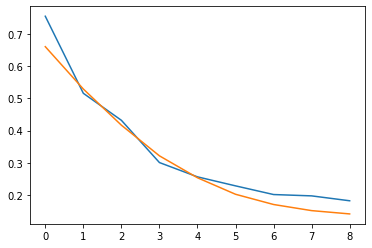

In [92]:
plt.plot(losses)
plt.plot(val_losses)

In [93]:
loaded_model = pickle.load(open(filename, 'rb'))

In [94]:
type(test_dataset)

torch.utils.data.dataloader.DataLoader

In [95]:
test_losses, test_preds  = [], []
transformer.eval()
for (x, y) in test_dataset:

    S = x.shape[-2]
    y_pred, _ = transformer(x, mask=create_look_ahead_mask(S))
    y = y.cpu().detach().numpy()*data.std(axis=0)+data.mean(axis=0)
    y_pred = y_pred.cpu().detach().numpy()*data.std(axis=0)+data.mean(axis=0)
    
    y = torch.tensor(y)
    y_pred = torch.tensor(y_pred)
    
    loss_test = torch.nn.MSELoss()(torch.tensor(y_pred),torch.tensor(y))  # (B,S)
    test_losses.append(loss_test.item())
    test_preds.append(y_pred.detach().cpu().numpy())
test_preds = np.vstack(test_preds)
np.mean(test_losses)

64.15618896484375

In [96]:
x_test, _ = test_dataset.dataset.tensors
x_test = x_test.cpu().detach().numpy()*data.std(axis=0)+data.mean(axis=0)

In [97]:
print(x_test)

[[[35.      ]
  [40.      ]
  [45.      ]
  [32.      ]
  [47.      ]
  [50.      ]
  [55.      ]
  [56.      ]
  [40.      ]
  [59.      ]
  [63.      ]
  [69.      ]]

 [[15.      ]
  [24.999998]
  [35.      ]
  [30.      ]
  [35.      ]
  [40.      ]
  [45.      ]
  [32.      ]
  [47.      ]
  [50.      ]
  [55.      ]
  [56.      ]]]


In [98]:
print(x_test.shape)

(2, 12, 1)


In [99]:
print(y.shape)

torch.Size([2, 12, 1])


In [100]:
print(y_pred.shape)

torch.Size([2, 12, 1])


In [101]:
seq_len = 12
index = np.random.randint(1,2)
feature_num = 0

In [102]:
x_test = x_test[index, :, feature_num]
pred = test_preds[index, :, feature_num]
x = np.linspace(1, seq_len, seq_len)

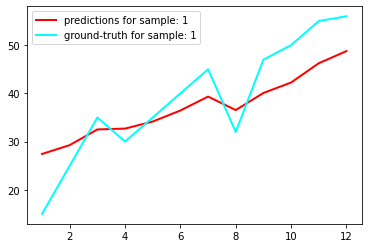

In [103]:

plt.plot(x, pred, 'red', lw=2, label='predictions for sample: {}'.format(index))
plt.plot(x, x_test, 'cyan', lw=2, label='ground-truth for sample: {}'.format(index))
plt.legend(fontsize=10)
plt.show()

In [104]:
pred

array([27.43073 , 29.271143, 32.521667, 32.69835 , 34.154236, 36.450565,
       39.33638 , 36.53672 , 40.081688, 42.249508, 46.250717, 48.763096],
      dtype=float32)

In [109]:
y_pred

tensor([[[38.6464],
         [41.9919],
         [46.3678],
         [42.0927],
         [47.5968],
         [50.6623],
         [54.3565],
         [55.9760],
         [50.5123],
         [56.9478],
         [59.8901],
         [63.3921]],

        [[27.4307],
         [29.2711],
         [32.5217],
         [32.6983],
         [34.1542],
         [36.4506],
         [39.3364],
         [36.5367],
         [40.0817],
         [42.2495],
         [46.2507],
         [48.7631]]])

In [111]:
y

tensor([[[40.0000],
         [45.0000],
         [32.0000],
         [47.0000],
         [50.0000],
         [55.0000],
         [56.0000],
         [40.0000],
         [59.0000],
         [63.0000],
         [69.0000],
         [55.0000]],

        [[25.0000],
         [35.0000],
         [30.0000],
         [35.0000],
         [40.0000],
         [45.0000],
         [32.0000],
         [47.0000],
         [50.0000],
         [55.0000],
         [56.0000],
         [40.0000]]])